# Install detectron2

In [14]:
#dependencies
!pip install --upgrade pip
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
torchvision.__version__
!gcc --version

# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.0.2)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /opt/conda/lib/python3.7/site-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /opt/conda/lib/python3.7/site-packages (0.5.0+cu100)
Processing /home/Deep_Learner/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9/PyYAML-5.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.2
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-4vwplioq
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-4vwplioq
  Created wheel for pycocotools: filena

# Imports

In [60]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
from bokeh.io import output_notebook
from typing import Dict, List, Callable
import os
import pandas as pd
import numpy as np
import torch, torchvision
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
from tqdm import tqdm_notebook as tqdm
import PIL
from PIL import Image
import sys
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
from wsi import tiles, util
import fastai
from fastai import vision
import matplotlib.pyplot as plt
 
PATH = Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/')
STAGE1_TRAIN = PATH/'stage1_train'
STAGE1_TEST = PATH/'stage1_test'
STAGE1_TRAIN_LABELS = PATH/'stage1_train_labels.csv'
STAGE1_TEST_LABELS = PATH/'stage1_solution'

seed = 19
np.random.seed(seed)

# util functions

In [101]:
def find_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    for p in base_path.ls():
        if img_id in p.stem:
            return p
    
def open_mask_as_np(path:pathlib.Path)->np.array:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np(arr:np.array):
    plt.imshow(arr)
    plt.show()
    
def merge_masks(masks:List[np.array], shape:tuple)->np.array:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple)->np.array:
    masks = [open_mask_as_np(p) for p in path.ls()]
    return merge_masks(masks, shape)

# dataset

In [21]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [22]:
s1_trn_lbs_df

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3
...,...,...
29456,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,31317 2 31676 5 32035 6 32394 7 32753 8 33112 ...
29457,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,110318 4 110675 13 111034 19 111391 23 111750 ...
29458,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,24841 1 25201 2 25561 2 25921 3 26281 4 26641 ...
29459,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,4061 8 4417 14 4775 21 5134 23 5494 24 5853 26...


In [35]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

In [44]:
img_id_p = find_path_from_id(img_id, STAGE1_TRAIN);

In [45]:
masks_path = img_id_p/'masks'

In [94]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [95]:
result = np.zeros((256,256), dtype=np.bool)
for mask in masks_np:
    result = np.maximum(result, mask)

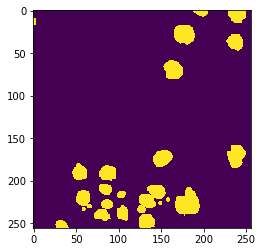

In [102]:
show_np(merge_masks_from_path(masks_path,(256,256)))

In [36]:
encoded_pixels = s1_trn_lbs_df.iloc[0][1];encoded_pixels

'6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440 9 8696 9 8952 9 9209 8 9465 8 9722 7 9978 7 10235 6 10493 4 10752 1'